In [11]:
from visualization.utils import O3DStreamPlot, o3d_coord, o3d_mesh, o3d_pcl, o3d_plot, o3d_skeleton, pcl_filter
import numpy as np
import open3d as o3d
from dataloader.result_loader import KinectResultLoader, ArbeResultLoader, OptitrackResultLoader, ResultFileLoader

class ArbeManager():
    def __init__(self, result_path) -> None:
        self.arbe_loader = ArbeResultLoader(result_path)

    def generator(self):
        for i in range(30, len(self.arbe_loader)):
            arbe_row = self.arbe_loader[i]
            yield arbe_row["arbe"]


class ArbeStreamPlot(O3DStreamPlot):
    def __init__(self, input_path: str, angle_of_view=[0,-1,0,1], *args, **kwargs) -> None:
        super().__init__(width=800, *args, **kwargs)
        self.input_path = input_path
        self.angle_of_view = angle_of_view

    def init_updater(self):
        self.plot_funcs = dict(
            arbe_pcls=o3d_pcl,
        )
    
    def init_show(self):
        super().init_show()
        self.ctr.set_up(np.array([0, 0, 1]))
        self.ctr.set_front(np.array(self.angle_of_view[:3]))
        self.ctr.set_zoom(self.angle_of_view[3])

    def generator(self, device: str = None):
        if device is None:
            device = self.devices[0]
        input_manager = ArbeManager(self.input_path)

        for arbe_row in input_manager.generator(device):
            # load numpy from file
            arbe_arr = np.load(arbe_row["filepath"])
            
            yield dict(
                arbe_pcls=dict(
                    pcl=arbe_arr[:,:3],
                    color=[0,1,0]
                ),
            )


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-08-09 18:10:44,098 - topics - topicmanager initialized


In [2]:
"""
Visualize optitrack skeleton and arbe pcl
"""
from visualization.o3d_plot import OptitrackArbeStreamPlot
from multiprocessing.dummy import Pool

def process(path, angle_of_view=[0,-1,0,1]):
    plot = ArbeStreamPlot(path, angle_of_view)
    plot.show()

# root_path = "/media/nesc525/backup/max21-09-09_17-03-33"
root_path = "/home/nesc525/drivers/5/mmvoice/2022-08-06_15-58-37"
pool = Pool()
pool.apply_async(process, (root_path, [0,-1,0,1]))
# pool.apply_async(process, (root_path, [1,1,0,2]))
# pool.apply_async(process, (root_path, [-1,1,0,2]))
pool.close()
pool.join()

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
No render setting


In [24]:
import wave
import math
import numpy as np
import matplotlib.pyplot as plt 

class Audiowave:
 
    def __init__(self,filedir):
        self.filedir=filedir
        self.wavedata=[]
        self.wavewidth=2
        self.wavechannel=2
        self.framerate = 0
        self.Timedata=[]
        self.nframes=0
    def waveopen(self):
        wf=wave.open(self.filedir,"rb")
        self.nframes = wf.getnframes()
        self.wavedata = wf.readframes(self.nframes)
        self.wavewidth=wf.getsampwidth()
        self.wavechannel=wf.getnchannels()
        self.framerate = wf.getframerate()
        time=self.nframes/self.framerate
        bps=self.framerate*self.wavewidth*8*self.wavechannel
        print("总帧数："+str(self.nframes)+"帧")
        print("采样率："+str(self.framerate)+"帧/s")
        print("声道数："+str(self.wavechannel)+"个")
        print("位深："+str(self.wavewidth*8)+"bit")
        print("比特率："+str(bps/1000)+"kbps")
        print("时间："+ str(time)+"s")
        print("文件大小："+ str(time*bps/8/1000)+"KB")
        return self.wavedata,self.wavewidth,self.wavechannel,self.framerate,time
 
 
 
    def wavehex_to_DEC(self,wavedata,wavewidth,wavechannel):
        n = int(len(wavedata) / wavewidth)
        i = 0
        j = 0
        for i in range(0, n):
            b = 0
            for j in range(0, wavewidth):
                temp = wavedata[i * wavewidth:(i + 1) * wavewidth][j] * int(math.pow(2, 8 * j))
                b += temp
            if b > int(math.pow(2, 8 * wavewidth - 1)):
                b = b - int(math.pow(2, 8 * wavewidth))
            self.Timedata.append(b)
        self.Timedata = np.array(self.Timedata)
        self.Timedata.shape = -1, wavechannel
        self.Timedata = self.Timedata.T
        x = np.linspace(0, len(self.Timedata[0]), len(self.Timedata[0])) / self.framerate
        return x,self.Timedata
 
    def to_fft(self,data):
        N=self.nframes #取样点数
        df = self.framerate / (N - 1)  # 分辨率
        freq = [df * n for n in range(0, N)]
        wave_data2 = data[0:N]
        c = np.fft.fft(wave_data2) * 2 / N
        d = int(len(c) / 2)
        freq=freq[:d - 1]
        fredata=abs(c[:d - 1])
 
        return freq,fredata
 
 
 
    def wavedraw1(self):
        self.waveopen()
        timedata=self.wavehex_to_DEC(self.wavedata,self.wavewidth,self.wavechannel)
        fredata=self.to_fft(timedata[1][0])
 
 
        plt.figure(figsize=(16, 8))
        plt.subplot(2,1,1)
        plt.plot(timedata[0], timedata[1][0])
        plt.xlabel(u"Time(S)")
        plt.subplot(212)
        plt.plot(fredata[0],fredata[1])
        plt.xlim(0, 800)
        plt.xlabel(u"Freq(Hz)")
 
        plt.subplots_adjust(hspace=0.4)
        plt.show()
 
    def wavedrawall(self):
        self.waveopen()
        n=self.wavechannel
        timedata = self.wavehex_to_DEC(self.wavedata, self.wavewidth, self.wavechannel)
        xtimedata=timedata[0]
        ytimedata=timedata[1]
        # print(ytimedata)
        i=0
        plt.figure(figsize=(30, 10))
        # plt.legend(prop=font_set)
        for i in range(0,n):
            a=plt.subplot(2, n, i+1)
            a.set_title("track"+str(i+1))
            plt.plot(xtimedata, ytimedata[i])
            plt.xlim(0, xtimedata[-1])
            plt.xlabel(u"Time(S)")
            # print(ytimedata[i])
            fredata = self.to_fft(ytimedata[i])
            plt.subplot(2,n,i+n+1)
            plt.plot(fredata[0], fredata[1])
            plt.xlim(0, 4000)
            plt.xlabel(u"Freq(Hz)")
        plt.subplots_adjust(hspace=0.4)
        # plt.show()

In [14]:
from sphfile import SPHFile
import os
 
def get_wave_path(wav_path):
	
	wave_files = []
	for (dirpath, dirname, filenames) in os.walk(wav_path):
		for filename in filenames:
			if filename.endswith('.wav') or filename.endswith('.WAV'):
				filename_path = os.path.join(dirpath, filename)
				
				wave_files.append(filename_path)
	
	return wave_files
 
def sphfile_trans_to_wave(wave_file):
	
	for wav in wave_file:
		file = SPHFile(wav)
		print(wav)
		file.write_wav(filename=f'{wav.split(".")[0]}_SPH.wav')

In [6]:
root_path = "/home/nesc525/drivers/5/mmvoice/2022-08-06_15-58-37"
wave_path = os.path.join(root_path, 'audio/id=0_st=1659772723.3297486.wav')
from ffmpy import FFmpeg
  
import os
  
  
# MP3转wav
def audio_transfor(audio_path: str, output_dir: str):
    ext = os.path.basename(audio_path).strip().split('.')[-1]
    if ext != 'mp3':
        return
  
    result = os.path.join(output_dir, '{}.{}'.format(''.join(os.path.basename(audio_path).strip().split('.')[:-1]), 'wav'))
    filter_cmd = '-f wav -ac 1 -ar 16000'
    ff = FFmpeg(
        inputs={
            audio_path: None}, outputs={
            result: filter_cmd})
    print(ff.cmd)
    ff.run()
    return result
  
  
def handle(audio_dir: str, output_dir: str):
    for x in os.listdir(audio_dir):
        audio_transfor(os.path.join(audio_dir, x), output_dir)

Loading .npy from /home/nesc525/drivers/5/mmvoice/2022-08-06_15-58-37/arbe


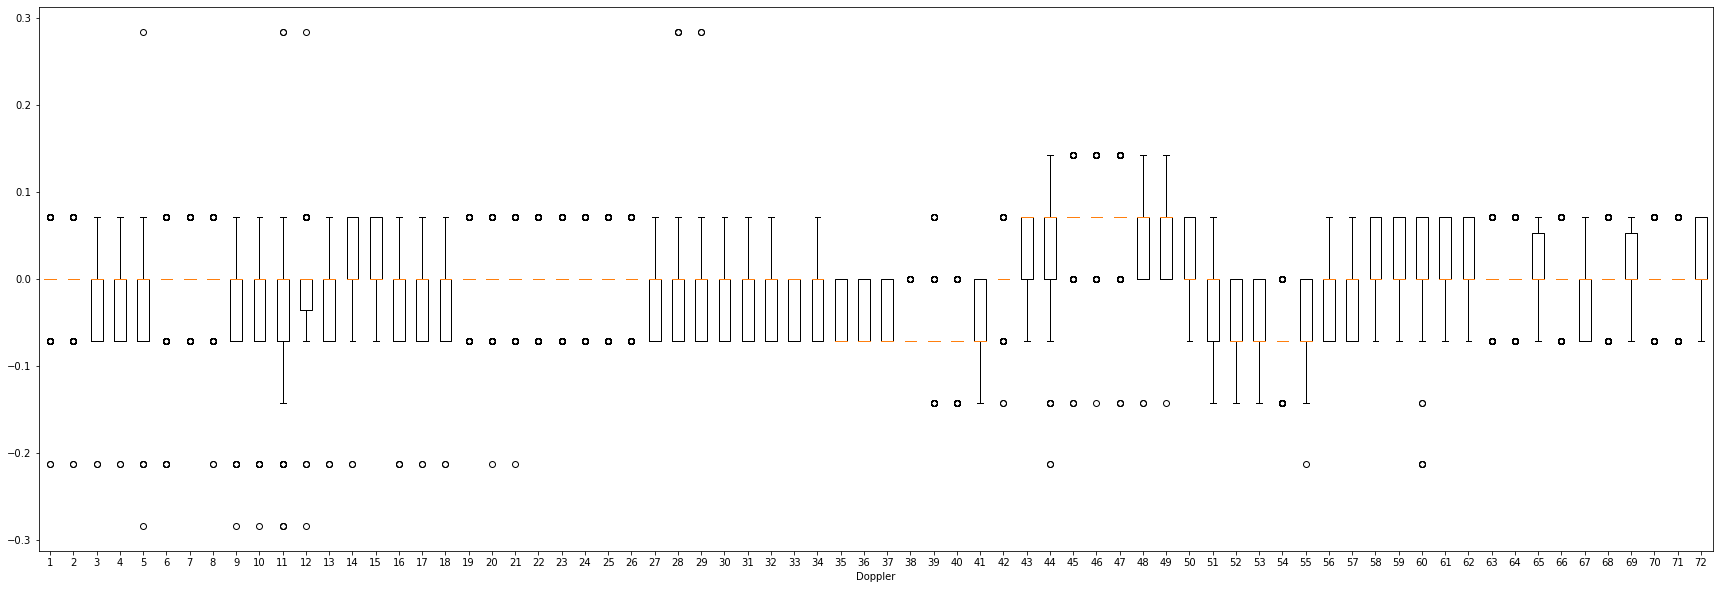

In [20]:
root_path = "/home/nesc525/drivers/5/mmvoice/2022-08-06_15-58-37"

arbe_loader = ArbeResultLoader(root_path)

max_dop = []
min_dop = []
_i = []
dop = []
index = 0
for i in range(0, len(arbe_loader)):
    arbe_row = arbe_loader[i]
    if arbe_row["arbe"]:
        arbe_arr = np.load(arbe_row["arbe"]["filepath"])
        arbe_arr = pcl_filter(np.array([[-0.2, 1.5, -0.2], [0.2, 2.5, 0.2]]), arbe_arr, 0)

        max_dop.append(arbe_arr[:, 7].max())
        min_dop.append(arbe_arr[:, 7].min())
        _i.append(index)
        dop.append(arbe_arr[:, 7])
        index +=1


plt.boxplot(dop)
plt.xlabel(u"Doppler")
plt.show()


# plt.plot(_i, max_dop, min_dop)
# plt.rcParams('figure.figsize')=(12,8)
# plt.rcParams["figure.figsize"] = (30,10)

# plt.show()


总帧数：177984帧
采样率：16000帧/s
声道数：1个
位深：16bit
比特率：256.0kbps
时间：11.124s
文件大小：355.968KB


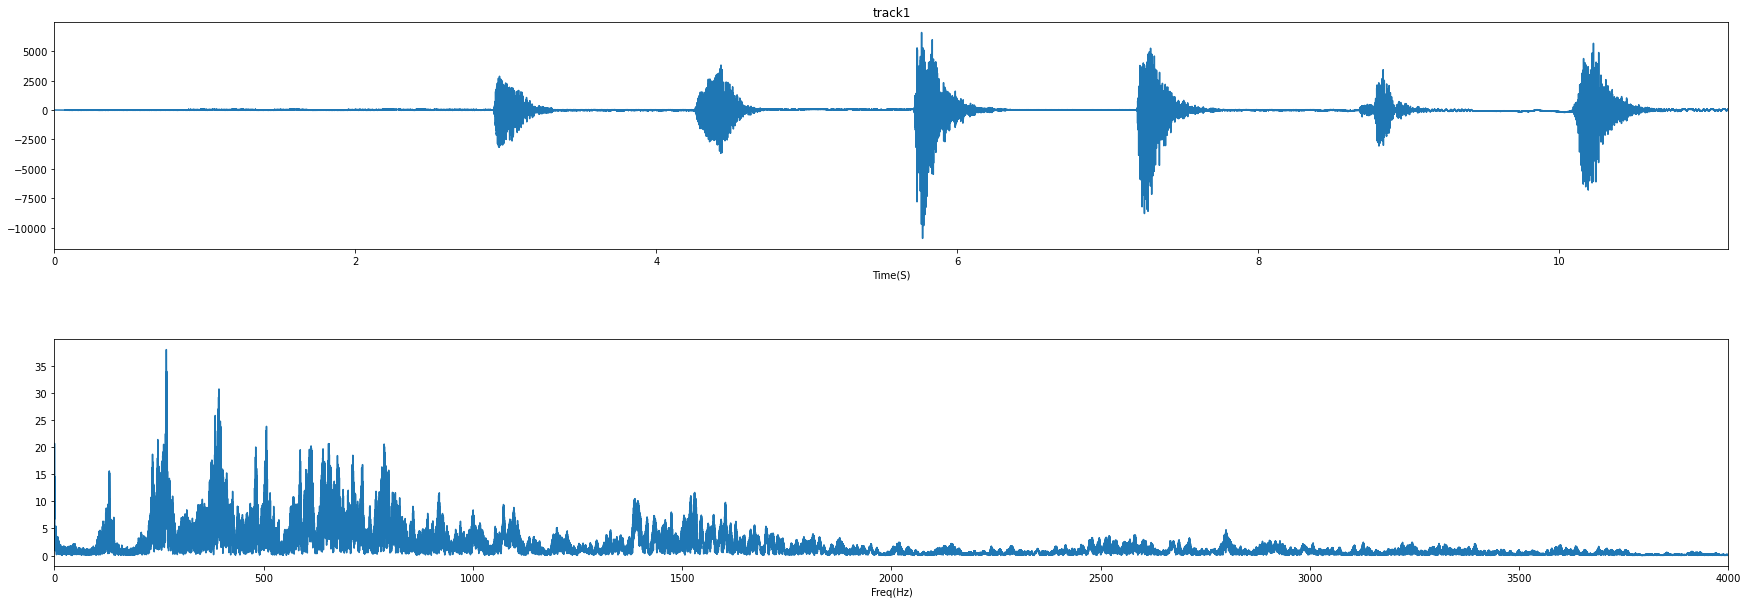

In [25]:
a=Audiowave(os.path.join(root_path, 'audio/id_0_st_1659772723.3297486.wav')).wavedrawall()
